# <center>Catch Me If You Can ("Alice")</center>

## Introduction

Here we try to identify a user on the Internet tracking his/her sequence of attended Web pages.  
The algorithm to be built will take a webpage session (a sequence of webpages attended consequently by the same person)  
and predict whether it belongs to Alice or somebody else.

The data comes from Blaise Pascal University proxy servers.  
Paper "A Tool for Classification of Sequential Data" by Giacomo Kahn, Yannick Loiseau and Olivier Raynaud.

### **Plan:**
* Analyze data and prepare training sample
* ROC AUC metric
* Logistic regression
* Baseline model creation

### **Input files:**
* sample_submission.csv
* train_session.csv
* test_session.csv
* site_dic.pkl – sites dictionary
* train.zip – initial data

**User sessions** are chosen in the way they are not longer than half an hour or/and contain more than ten websites.  
I.e. a session is considered as ended either if a user has visited ten websites or if a session has lasted over thirty minutes.

### **Link to kaggle competition:**
* [Catch Me If You Can ("Alice")](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2)

In [ ]:
import pandas as pd
import pickle
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, plot_confusion_matrix

## **Data description**
site1 – id of the first visited website in the session  
time1 – visiting time for the first website in the session  
...  
site10 – id of the tenth visited website in the session  
time10 – visiting time for the tenth website in the session  
target – target variable, possesses value of 1 for Alice's sessions, and 0 for the other users' sessions  
  
time1 - start of session, that's why we can convert this values to date and sort all sessions by this value

In [ ]:
#WARNING! Working with local data please find them in <dataset/ML_Weekly/5/dataset.zip>

# Read the training and test data sets
train_df = pd.read_csv('./data/train_sessions.csv',
                       index_col='session_id',parse_dates=['time1'])
test_df = pd.read_csv('./data/test_sessions.csv',
                      index_col='session_id',parse_dates=['time1'])
train_df.head()

In [ ]:
train_df.get_ftype_counts()

In [ ]:
test_df.get_ftype_counts()

In [ ]:
# Change of time columns types to datetime.
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

In [ ]:
'''
Change of site columns types to integer.
But some of the site values have Na-val so such values should be converted to zeros.
'''
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

In [ ]:
# Sort the data by time
train_df = train_df.sort_values(by='time1')
train_df.head()

In [ ]:
train_df.get_ftype_counts()

In [ ]:
test_df.get_ftype_counts()

In [ ]:
'''
Creation of dataframe for site dictionary. Where:
index - site id
site - name of site
'''
with open(r"./data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
sites_dict.head()

In [ ]:
print(u'Shape of train dataframe:', train_df.shape)
print(u'Shape of test dataframe: ', test_df.shape)

In [ ]:
sns.countplot(train_df['target'])

In [ ]:
# Top websites in the training data set
top_sites = pd.Series(
    train_df[sites]
    .values
    .flatten()
).value_counts().sort_values(ascending=False).head()

top_sites

In [ ]:
# Alice's preferences
top_sites_alice = pd.Series(
    train_df[train_df.target==1][sites]
    .values
    .flatten()
).value_counts().sort_values(ascending=False).head()

top_sites_alice

In [ ]:
y_train = train_df['target'].values

In [ ]:
# Transform data into format which can be fed into CountVectorizer.
train_df[sites].to_csv('train_sessions_text.txt', sep=' ', index=None, header=None)
test_df[sites].to_csv('test_sessions_text.txt', sep=' ', index=None, header=None)

## **Bag of words**  
A bag-of-words is a representation of text that describes the occurrence of words within a document. It involves two things:  
* A vocabulary of known words.
* A measure of the presence of known words.

## **Bag of words with CountVectorizer() example:**
>```vectorizer = CountVectorizer()
corpus = [
  'site_1 site_2 site_3',
  'site_2 site_3',
  'site_1 site_2 site_1',
  'site_4'
]
X = vectorizer.fit_transform(corpus)
```
 
>result:

>| | site_1 | site_2 | site_3 | site_4
 :---: | :---: | :---: | :---: | :---:
session_1 | 1 | 1 | 1 | 0
session_2 | 0 | 1 | 1 | 0
session_3 | 2 | 1 | 0 | 0
session_4 | 0 | 0 | 0 | 1


In [ ]:
# Fit CountVectorizer and trasfrom data with it.
cv = CountVectorizer(ngram_range=(1, 3), max_features=50000)
with open('train_sessions_text.txt') as inp_train_file:
    X_train = cv.fit_transform(inp_train_file)
with open('test_sessions_text.txt') as inp_test_file:
    X_test = cv.transform(inp_test_file)
print(X_train.shape, X_test.shape)
cv.get_feature_names()[:10]

## **Logistic regression**  
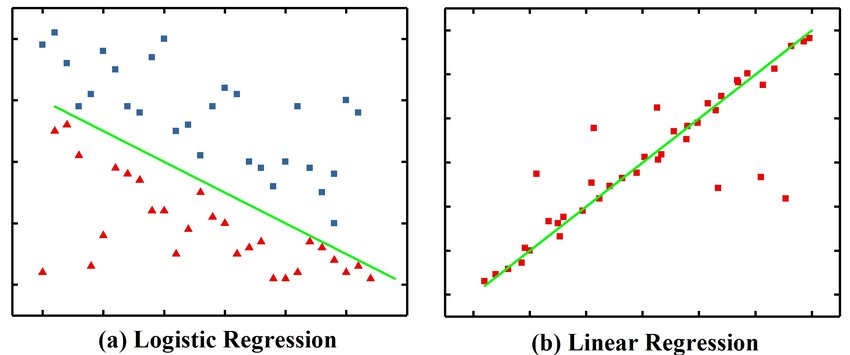

logistic-regression.png

$P_{+} = sigm(w^{T}x)$

## **ROC AUC**  
### **Confusion matrix:**
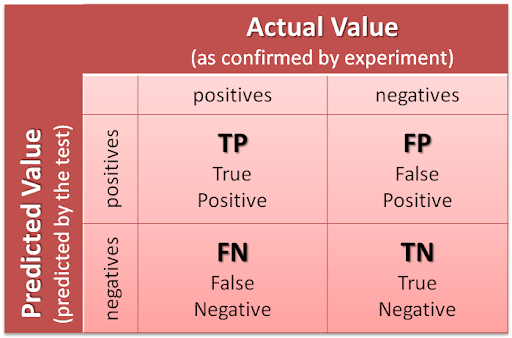  
  
$TPR = TP / (TP + FN)$  
$FPR = FP / (FP + TN)$  
  
### **ROC curve:**
ROC-curve.png


In [ ]:
def show_roc_curve(y_valid, y_pred):
    fpr, tpr, threshold = roc_curve(y_valid, y_pred)
    plt.figure(figsize=(8,5))
    plt.title('Receiver Operating Characteristic Curve')
    plt.plot(fpr, tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')


In [ ]:
def get_auc_lr_valid(X, y, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))

    x_train = X[:idx, :]
    y_train = y[:idx]
    x_test = X[idx:, :]
    y_test = y[idx:]

    # Classifier training
    lr = LogisticRegression(random_state=seed, max_iter=500)
    lr.fit(x_train, y_train)

    # Prediction for validation set
    y_pred = lr.predict_proba(x_test)[:, 1]
    # Calculate the quality
    score = roc_auc_score(y_test, y_pred)
    # Show ROC AUC curve
    show_roc_curve(y_test, y_pred)
    return score

In [ ]:
# Calculate metric on the validation set
roc_auc = get_auc_lr_valid(X_train, y_train)

In [ ]:
print(f"ROC AUC SCORE: {roc_auc}")